# Quantum State Preparation Circuit

This code creates the quantum circuit for quantum state preparation base on [1]. All the calculation for the angles and the circuit itself can be see in the paper.

[1] A divide‑and‑conquer algorithm for quantum state preparation - https://www.nature.com/articles/s41598-021-85474-1

In [412]:
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.visualization import plot_histogram
import math
import qiskit.quantum_info as qi
from sklearn.preprocessing import normalize

Function to calculate the angles inside the Ry gates.

In [413]:
def gen_angles(x):
    """ This function give the angles for state preparation given 
        a set on probabilities in the quantum circuit.
        input:
            x : list = array of probabilities for the state.append
        output:
            angles: angles for the quantum circuit.

        Example:
            x = [np.sqrt(0.5),np.sqrt(0.2),np.sqrt(0.1),np.sqrt(0.3)]
        Where:
            0.5+0.2+0.1+0.3 = 1
        Output:
            array([1.2945, 1.1278, 2.0943])
    """

    angles = np.zeros(int(len(x)/2))
    if len(x)>1:
        new_x = np.zeros(int(len(x)/2))

        for k in range(0, len(new_x)):
            new_x[k] = np.sqrt(np.abs(x[2*k])**2+np.abs(x[2*k+1])**2)

        inner_angles = gen_angles(new_x)
        angles = np.zeros(int(len(x)/2))
        
        for k in range(0, len(new_x)):
            if new_x[k] != 0:
                if x[2*k] > 0:
                    angles[k] = 2*np.arcsin((x[2*k+1])/(new_x[k]))
                else:
                    angles[k] = 2*np.pi-2*np.arcsin((x[2*k+1])/(new_x[k]))
            else:
                angles[k] = 0

        angles = np.concatenate((inner_angles,angles))
    return angles

In [414]:
def apply_gate(qc, num_qubits, value):
    """ This function add the N-control Ry gate given a 
        quantum circuit.
        input:
            qc : QuantumCircuit 
            num_qubits: which qubits are gona be affected.
            value : float = value for the Ry gate.
    """
    if num_qubits == 0:
        qc.ry(value, 0) 
    elif num_qubits == 2:
        c3h_gate = RYGate(value).control(1)
        qc.append(c3h_gate, [0,1])
    elif num_qubits == 3:
        c3h_gate = RYGate(value).control(2)
        qc.append(c3h_gate, [0,1,2])
    elif num_qubits == 4:
        c3h_gate = RYGate(value).control(3)
        qc.append(c3h_gate, [0,1,2,3])

In [415]:
gen_angles([np.sqrt(0.5),np.sqrt(0.2),np.sqrt(0.1),np.sqrt(0.3)])

array([1.2945697 , 1.12788528, 2.0943951 ])

State preparation quantum circuit.

In [416]:
def state_preparation(prob, if_measure):

    qc = QuantumCircuit(math.log2(len(prob)), math.log2(len(prob)))
    prob = prob / np.linalg.norm(prob)
    state = np.sqrt(prob)
    angles = gen_angles(state)

    ### Add quantum gates to the circuit.

    apply_gate(qc, 0, angles[0])
    qc.barrier() # barrier for better visualization.

    for val in range(2, len(angles)+1):
        num_qubits_required = math.ceil(math.log2(val+1)) if val != 0 else 1
        binary_val = format(val, f'0{num_qubits_required}b')[::-1]

        binary_val = binary_val[0:num_qubits_required-1][::-1]

        for k, bit in enumerate(binary_val):
            if bit == '0':
                qc.x(k)
        
        apply_gate(qc, num_qubits_required, angles[val-1])

        for k, bit in enumerate(binary_val):
            if bit == '0':
                qc.x(k)

        qc.barrier()

    if if_measure == 1:
        measure_qubits = np.arange(int(math.log2(len(prob))))
        qc.measure(measure_qubits, measure_qubits[::-1])

    return qc

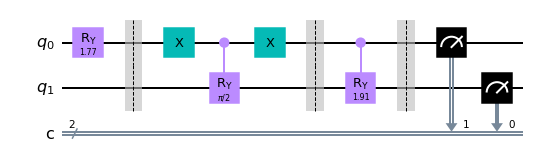

In [421]:
#prob = [0.3,0.3,0.3,0.1]
prob = [1,1,1,2]

qc = state_preparation(prob, 1)
qc.draw('mpl')

Simulation for testing the quantum circuit.

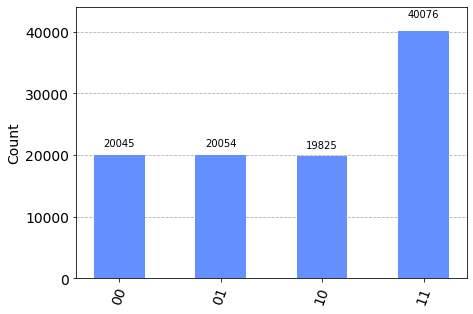

In [422]:
Simulation = Aer.get_backend('qasm_simulator')
Quantum_Transpiler = transpile(qc,Simulation)
Quantum_Obj = assemble(Quantum_Transpiler, shots=100000)
Result = Simulation.run(Quantum_Obj).result().get_counts()

plot_histogram(Result)